In [1]:
import os
import random
import sys
import platform
import cv2

import pandas as pd
from sklearn.impute import SimpleImputer

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import zscore
import seaborn as sns
from scipy.spatial.distance import euclidean
import math
from matplotlib.patches import Wedge, Ellipse, Polygon, Circle


def check_os():
    os = platform.system()

    if os == "Darwin":
        return "MacOS"
    elif os == "Linux":
        return "Linux"
    else:
        return "Unknown OS"

In [2]:
operating_system = check_os()

if operating_system == "MacOS":
    root_path = "/Users/johnny/Projects/"
elif operating_system == "Linux":
    root_path = "/home/johnny/Projects/"

In [3]:
def parse_annotation_file(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    data = []
    for line in lines:
        elements = line.split()
        id_ = elements[0]
        class_ = elements[1]
        x = int(elements[2])
        y = int(elements[3])
        width = int(elements[4])
        height = int(elements[5])
        occlusion = int(elements[6])
        # loitering = int(elements[7])

        # data.append([id_, class_, x, y, width, height, occlusion, loitering])
        data.append([id_, class_, x, y, width, height, occlusion])

    return data

In [4]:
if not os.path.exists(
    root_path + "/Master_Thesis_CV/datasets/annotations_original.csv"
):
    # Raíz de la carpeta de datos

    root_folder = os.path.join(root_path, "datasets/harbor-synthetic/annotations/")

    # Crear un dataframe vacío para almacenar todos los datos
    df = pd.DataFrame(columns=["id", "class", "x", "y", "width", "height", "occlusion"])
    # Crear una lista vacía para almacenar todos los dataframes
    dfs = []
    # Recorrer todas las carpetas y subcarpetas
    for folder, subfolders, files in tqdm(os.walk(root_folder)):
        # example '/Users/johnny/Projects/datasets/harbor-synthetic/annotations/20210220/clip_6_0248'
        temp_split = folder.split("/")
        clip_name = temp_split[-1]
        folder_name = temp_split[-2]
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(folder, file)
                data = parse_annotation_file(file_path)
                # frame_name = file.split('.')[0]
                frame_name = file.split("_")[-1].split(".")[0]
                # Añadir el nombre de la carpeta y el clip a cada fila
                for row in data:
                    row.insert(0, frame_name)
                    row.insert(0, clip_name)
                    row.insert(0, folder_name)

                # Añadir los datos a la lista de dataframes
                dfs.append(
                    pd.DataFrame(
                        data,
                        columns=[
                            "folder",
                            "clip",
                            "frame",
                            "id",
                            "class",
                            "x",
                            "y",
                            "width",
                            "height",
                            "occlusion",
                        ],
                    )
                )

    # Concatenar todos los dataframes
    df = pd.concat(dfs, ignore_index=True)

    # guardar el dataframe en un archivo csv
    # path actual de la carpeta
    path_actual = os.getcwd()

    df.to_csv(
        root_path + "Master_Thesis_CV/datasets/" + "annotations_original.csv",
        index=False,
    )

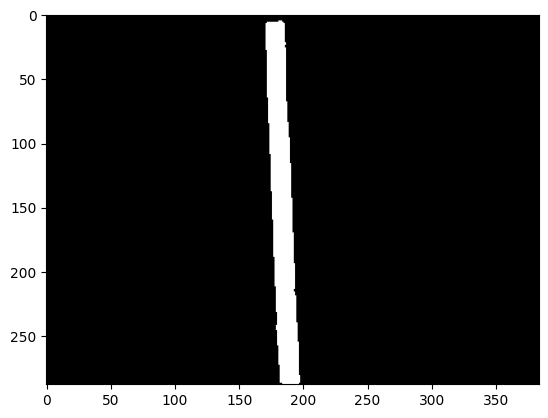

In [5]:
df = pd.read_csv(
    root_path + "/Master_Thesis_CV/datasets/annotations_original.csv"
).sort_values(by=["id", "frame"])
df.fillna(0, inplace=True)

# REMOVE TAMPERING
TAMPERING_VIDEOS = [
    "clip_23_1041",  # crane opertaing in front of camera
    "clip_36_1627",  # camera freezes, stutters
    "clip_37_1655",  # camera freezes, stutters
    "clip_28_1238",  # camera freezes, stutters
    "clip_40_2312",  # camera freezes, stutters
    "clip_13_0604",  # camera freezes, stutters
    "clip_14_0632",  # camera freezes, stutters
    "clip_20_0923",  # camera freezes, stutters
    "clip_21_0951",  # camera freezes, stutters
    "clip_26_1211",  # camera freezes, stutters
    "clip_27_1239",  # camera freezes, stutters
    "clip_28_1434",  # camera freezes, stutters
    "clip_23_1047",  # camera freezes, stutters
    "clip_9_0412",  # camera freezes, stutters
    # 20200516_clip_39_1726
    "20200526/clip_36_1617",  # faulty bounding boxes
    "20200526/clip_38_1713",  # faulty bounding boxes
    "20200614/clip_47_2057",  # faulty bounding boxes
    "20200521/clip_31_1359",  # faulty bounding boxes
    "20200614/clip_39_1727",  # faulty bounding boxes
    "20200601/clip_36_1614",
    "20210426/clip_32_1427",  # wrong annotations
    "20200526/clip_38_1713",  # wrong annotations
    "20200520_clip_46_2014",  # wrong annotations
]

WRONG_ANNOTATIONS = []

# remove tampering if clip is in TAMPERING_VIDEOS
df = df[~df["clip"].isin(TAMPERING_VIDEOS)]

# delete duplicates
df = df.drop_duplicates(
    subset=[
        "folder",
        "clip",
        "frame",
        "class",
        "x",
        "y",
        "width",
        "height",
        "occlusion",
    ],
    keep="first",
)
seg_img = cv2.imread("binary_mask.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(seg_img, cmap="gray")

In [6]:
def is_in_white(x, y):
    """Return True if the point is in the white area of the image."""
    # Check if the coordinates are within the image dimensions
    if 0 <= y < seg_img.shape[0] and 0 <= x < seg_img.shape[1]:
        return seg_img[y, x] == 255  # 255 is the value for white in grayscale images
    else:
        return False


# Apply the function to the dataframe and create a boolean mask
mask = df.apply(lambda row: is_in_white(row["x"], row["y"]), axis=1)

# Use the mask to filter rows
df = df[~mask]
df.to_csv(root_path + "Master_Thesis_CV/datasets/" + "annotations.csv", index=False)

In [7]:
MATRIX_PATH = root_path + '/Master_Thesis_CV/datasets/perspective_matrix.txt'

def transform_points(pts1):
    M = np.loadtxt(MATRIX_PATH, delimiter=',')
    pts2 = cv2.perspectiveTransform(pts1, M)
    return pts2


def transform_df_points(df):
    M = np.loadtxt(MATRIX_PATH, delimiter=',')

    df_pts = df[['x', 'y']]
    pts1 = df_pts.to_numpy(dtype=np.float32)
    pts1 = np.expand_dims(pts1, axis=0)

    pts2 = cv2.perspectiveTransform(pts1, M)
    df['x_transform'] = pts2[0, :, 0]
    df['y_transform'] = pts2[0, :, 1]
    return df

df = transform_df_points(df)
df = df[df["class"] == "human"]
# exists nan?
df.isnull().values.any()

False

In [8]:
# convert to int id column
df['id'] = df['id'].astype(int)
folders_to_keep = [
    20200514, 20200515, 20200516, 20200517, 20200518, 20200519, 20200520, 
    20200521, 20200522, 20200523, 20200524, 20200525, 20200526, 20200830, 
    20200831, 20200901, 20210108, 20210109, 20210110, 20210228, 20210301, 
    20210302, 20210303, 20210304, 20210305, 20210411, 20210412, 20210413, 
    20210414, 20210415, 20210416
]

print(len(df))
df = df[df['folder'].isin(folders_to_keep)]
print(len(df))
df.to_csv(root_path + '/Master_Thesis_CV/datasets/folders.csv', index=False)

import numpy as np
import pandas as pd

ids = pd.read_csv(root_path + 'Master_Thesis_CV/datasets/ids_final_combined.csv', header=None)
ids[0] = ids[0].astype(int)
ids = ids[0].values.tolist()

# save the ids
np.save(root_path + 'Master_Thesis_CV/datasets/ids.npy', ids)

# save csv from ids
ids_df = pd.DataFrame(ids)
ids_df.to_csv(root_path + 'Master_Thesis_CV/datasets/ids.csv', index=False, header=False)

ids_ = pd.read_csv(root_path + 'Master_Thesis_CV/datasets/ids.csv', header=None)
# ids_ to list
ids_ = ids_[0].values.tolist()

# create column in annotations
df['loitering'] = 0

# Use isin to check if each id in annotations is in ids_
df['loitering'] = df['id'].isin(ids_).astype(int)

# same by deleting the ids that are not in ids_
GT_ANNOTATIONS = df[df['id'].isin(ids_)]

GT_ANNOTATIONS.to_csv(root_path + 'Master_Thesis_CV/datasets/annotations_gt.csv', index=False)

# save annotations
df.to_csv(root_path + 'Master_Thesis_CV/datasets/annotations_loitering.csv', index=False)
grouped_by_id = df.groupby('id').size()

5643615
874936


In [9]:
df

,folder,clip,frame,id,class,x,y,width,height,occlusion,x_transform,y_transform,loitering
5803877,20200514,clip_0_1331,49,3,human,108,95,113,111,1,1021.293152,14766.603516,0
5804000,20200514,clip_0_1331,50,3,human,109,96,114,112,0,1003.861755,14300.315430,0
5804074,20200514,clip_0_1331,51,3,human,110,96,115,113,1,1015.966675,14253.065430,0
5803991,20200514,clip_0_1331,52,3,human,111,96,116,113,0,1027.992065,14206.126953,0
5803955,20200514,clip_0_1331,53,3,human,112,96,118,113,0,1039.938477,14159.495117,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543553,20200526,clip_38_1713,112,145575,human,142,109,147,121,1,1019.670471,9454.885742,0
2543671,20200526,clip_38_1713,113,145575,human,147,111,153,122,1,1020.687561,8951.686523,0
2544427,20200526,clip_38_1713,114,145575,human,153,112,161,126,1,1049.000000,8649.334961,0
2544461,20200526,clip_38_1713,115,145575,human,158,113,166,129,1,1068.111938,8381.507812,0


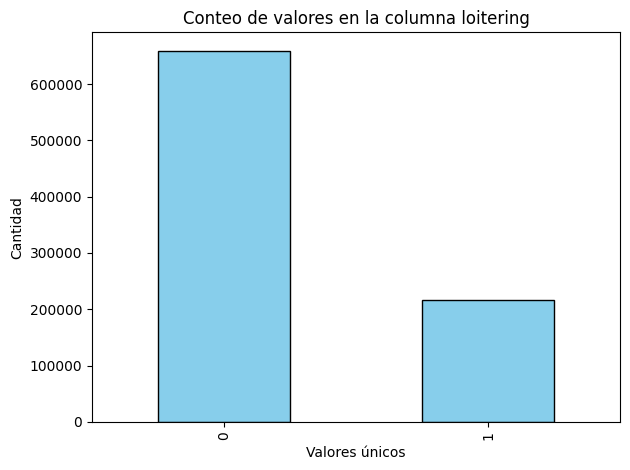

In [10]:
value_counts_1 = df['loitering'].value_counts()

# Bar plot
value_counts_1.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Conteo de valores en la columna loitering')
plt.xlabel('Valores únicos')
plt.ylabel('Cantidad') # Rotación de las etiquetas del eje x para mejor visualización
plt.tight_layout()  # Asegurarse de que todo se visualice correctamente
plt.show()

In [40]:
"""columns_to_normalize = ['x', 'y', 'x_transform', 'y_transform']

# Perform Min-Max scaling
for column in columns_to_normalize:
    min_val = df[column].min()
    max_val = df[column].max()
    df[f'{column}'] = (df[column] - min_val) / (max_val - min_val)"""


"columns_to_normalize = ['x', 'y', 'x_transform', 'y_transform']\n\n# Perform Min-Max scaling\nfor column in columns_to_normalize:\n    min_val = df[column].min()\n    max_val = df[column].max()\n    df[f'{column}'] = (df[column] - min_val) / (max_val - min_val)"

In [18]:
coord_dict = {}
coord_dict_ipm = {}

for id in tqdm(df["id"].unique()):
    # Filtra el DataFrame para solo ese ID
    df_id = df[df["id"] == id]
    # Crea una lista de tuplas de las coordenadas x, y para ese ID
    coord_list = list(zip(df_id["x"], df_id["y"]))
    coord_list_ipm = list(zip(df_id["x_transform"], df_id["y_transform"]))
    # Agrega esta lista al diccionario con la clave siendo el ID
    coord_dict[id] = coord_list
    coord_dict_ipm[id] = coord_list_ipm

# save coord_dict to file
import pickle

with open(root_path + "Master_Thesis_CV/datasets/" + "coord_dict.pkl", "wb") as handle:
    pickle.dump(coord_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(root_path + "Master_Thesis_CV/datasets/" + "coord_dict_ipm.pkl", "wb") as handle:
    pickle.dump(coord_dict_ipm, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 19737/19737 [00:07<00:00, 2632.62it/s]


In [19]:
"""
from rdp import rdp

# do it for coords and coords_transform
# Recorre cada ID único en el DataFrame
coord_dict_simplified = {}
for ID, path in tqdm(coord_dict.items(), leave=True, position=0):
    # Simplifica la trayectoria usando el algoritmo RDP
    path = np.array(path)
    path = rdp(path, epsilon=30)
    # Agrega la trayectoria simplificada al diccionario
    coord_dict_simplified[ID] = path
    
# save coord_dict to file
import pickle

with open(
    root_path + "Master_Thesis_CV/datasets/" + "coord_dict_smooth.pkl", "wb"
) as handle:
    pickle.dump(coord_dict_simplified, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""

'\nfrom rdp import rdp\n\n# do it for coords and coords_transform\n# Recorre cada ID único en el DataFrame\ncoord_dict_simplified = {}\nfor ID, path in tqdm(coord_dict.items(), leave=True, position=0):\n    # Simplifica la trayectoria usando el algoritmo RDP\n    path = np.array(path)\n    path = rdp(path, epsilon=30)\n    # Agrega la trayectoria simplificada al diccionario\n    coord_dict_simplified[ID] = path\n    \n# save coord_dict to file\nimport pickle\n\nwith open(\n    root_path + "Master_Thesis_CV/datasets/" + "coord_dict_smooth.pkl", "wb"\n) as handle:\n    pickle.dump(coord_dict_simplified, handle, protocol=pickle.HIGHEST_PROTOCOL)\n'

In [20]:
from scipy.signal import savgol_filter
import numpy as np

# Default Savitzky-Golay parameters
window_length = 11
poly_order = 3

# Dictionary to store smoothed coordinates
smoothed_coord_dict = {}

# Apply Savitzky-Golay filter to each ID in the dictionary
for id, coords in tqdm(coord_dict.items(), leave=True, position=0):
    if len(coords) < window_length:
        # Skip if not enough data points to apply the filter
        smoothed_coord_dict[id] = coords
        continue
    
    x_coords = np.array([x for x, y in coords])
    y_coords = np.array([y for x, y in coords])
    
    x_smoothed = savgol_filter(x_coords, window_length, poly_order)
    y_smoothed = savgol_filter(y_coords, window_length, poly_order)
    
    smoothed_coords = np.array(list(zip(x_smoothed, y_smoothed)))
    smoothed_coord_dict[id] = smoothed_coords

# save coord_dict to file
import pickle

with open(
    root_path + "Master_Thesis_CV/datasets/" + "coord_dict_smooth.pkl", "wb"
) as handle:
    pickle.dump(smoothed_coord_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 19737/19737 [00:03<00:00, 6444.43it/s]


In [21]:
from scipy.signal import savgol_filter
import numpy as np

# Default Savitzky-Golay parameters
window_length = 11
poly_order = 3

# Dictionary to store smoothed coordinates
smoothed_coord_dict_ipm = {}

# Apply Savitzky-Golay filter to each ID in the dictionary
for id, coords in tqdm(coord_dict_ipm.items(), leave=True, position=0):
    if len(coords) < window_length:
        # Skip if not enough data points to apply the filter
        smoothed_coord_dict_ipm[id] = coords
        continue
    
    x_coords = np.array([x for x, y in coords])
    y_coords = np.array([y for x, y in coords])
    
    x_smoothed = savgol_filter(x_coords, window_length, poly_order)
    y_smoothed = savgol_filter(y_coords, window_length, poly_order)
    
    smoothed_coords = np.array(list(zip(x_smoothed, y_smoothed)))
    smoothed_coord_dict_ipm[id] = smoothed_coords

# save coord_dict to file
import pickle

with open(
    root_path + "Master_Thesis_CV/datasets/" + "coord_dict_smooth_ipm.pkl", "wb"
) as handle:
    pickle.dump(smoothed_coord_dict_ipm, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 19737/19737 [00:03<00:00, 6475.96it/s]


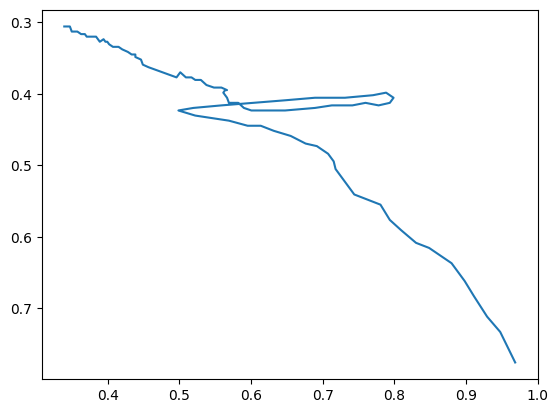

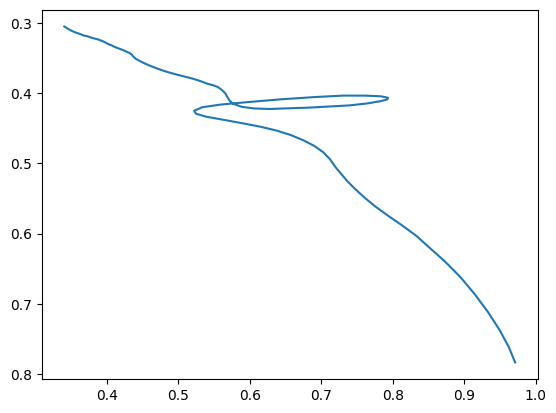

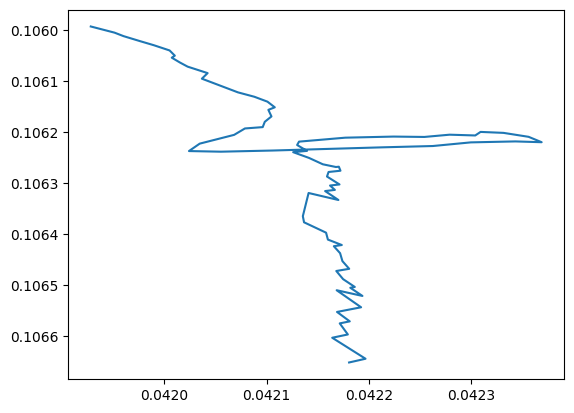

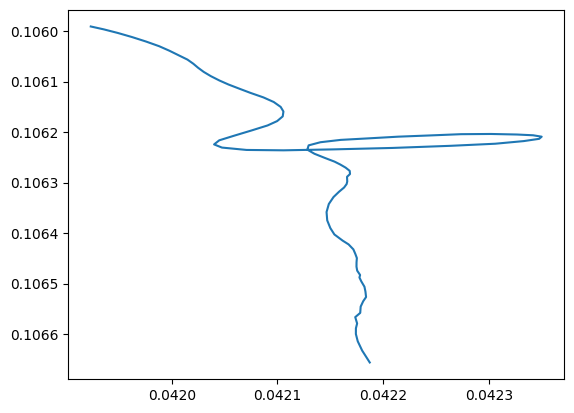

In [22]:
id_112 = coord_dict[112]
id_112 = np.array(id_112)
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()


"""id_112 = coord_dict_simplified[112]
# id_112 = rdp(id_112, epsilon=30)
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()"""

id_112 = smoothed_coord_dict[112]
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()

id_112 = coord_dict_ipm[112]
id_112 = np.array(id_112)
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()

id_112 = smoothed_coord_dict_ipm[112]
plt.plot(id_112[:, 0], id_112[:, 1])
plt.gca().invert_yaxis()
plt.show()

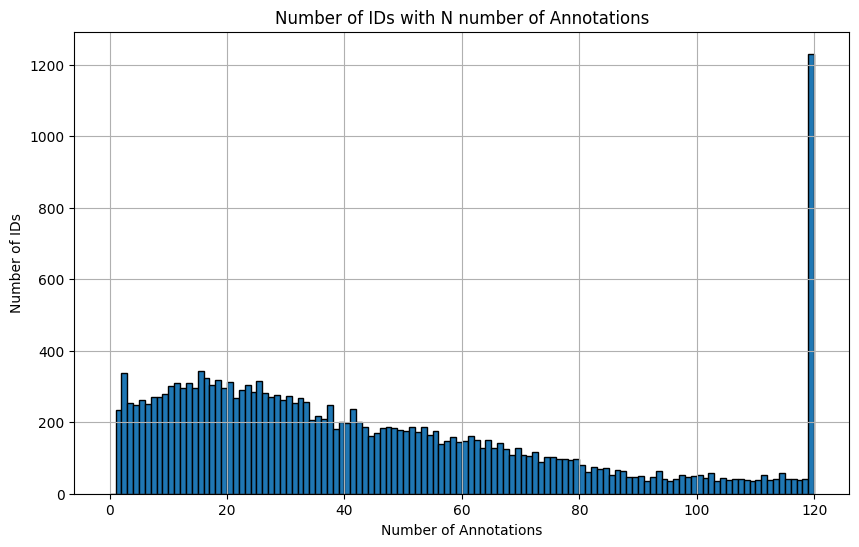

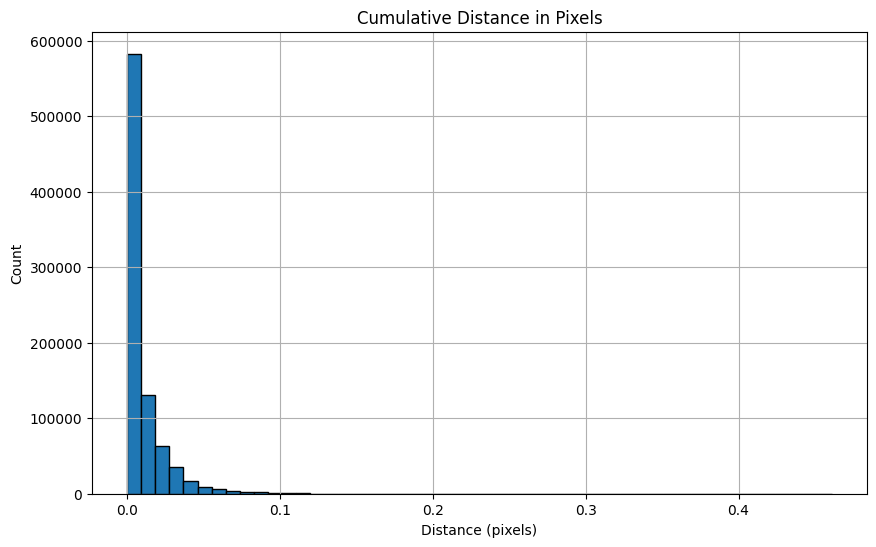

{'Overall_Avg_Coord_X': 0.43990908723383476,
 'Overall_Avg_Coord_Y': 0.3951282176038559,
 'Overall_Avg_Distance': 0.009731746649842644,
 'Overall_Total_Points': 874936,
 'Overall_Avg_Total_Points': 44.329736028778434,
 'Overall_Range_X': 0.3234626793088975,
 'Overall_Range_Y': 0.18789036379704185}

In [23]:
# Initialize variables to store total metrics
total_avg_x = []
total_avg_y = []
total_avg_distance = []
total_points = []
total_range_x = []
total_range_y = []

def calc_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Loop through each ID to gather metrics
for obj_id, coords in smoothed_coord_dict.items():
    coords = np.array(coords)  # Make sure it's a numpy array
    
    # Average x and y coordinates
    total_avg_x.extend(coords[:, 0])
    total_avg_y.extend(coords[:, 1])
    
    # Calculate average distance between consecutive points
    distances = [calc_distance(coords[i, 0], coords[i, 1], coords[i+1, 0], coords[i+1, 1]) for i in range(len(coords)-1)]
    total_avg_distance.extend(distances)
    
    # Total points
    total_points.append(len(coords))
    
    # Range for x and y
    total_range_x.append(np.max(coords[:, 0]) - np.min(coords[:, 0]))
    total_range_y.append(np.max(coords[:, 1]) - np.min(coords[:, 1]))

# Calculate the overall metrics
overall_metrics = {
    'Overall_Avg_Coord_X': np.mean(total_avg_x),
    'Overall_Avg_Coord_Y': np.mean(total_avg_y),
    'Overall_Avg_Distance': np.mean(total_avg_distance),
    'Overall_Total_Points': np.sum(total_points),
    'Overall_Avg_Total_Points': np.mean(total_points),
    'Overall_Range_X': np.mean(total_range_x),
    'Overall_Range_Y': np.mean(total_range_y),
}

plt.figure(figsize=(10, 6))
plt.hist(total_points, bins=range(0, 121), edgecolor='black')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of IDs')
plt.title('Number of IDs with N number of Annotations')
plt.grid(True)
plt.savefig(root_path + 'Master_Thesis_CV/plots/hist_frames.pdf')
plt.show()

# Second Histogram: Cumulative distance in pixels
plt.figure(figsize=(10, 6))
plt.hist(total_avg_distance, bins=50, edgecolor='black')
plt.xlabel('Distance (pixels)')
plt.ylabel('Count')
plt.title('Cumulative Distance in Pixels')
plt.grid(True)
plt.savefig(root_path + 'Master_Thesis_CV/plots/dist.pdf')
plt.show()

overall_metrics


# Machine Learning

In [24]:
gt_df = pd.read_csv(root_path + "/Master_Thesis_CV/datasets/gt_df.csv")

In [25]:
# original coord_dict
# rdp simplified_coord_dict
# golay smoothed_coord_dict
# Align the data by filtering only the IDs that exist in both datasets


common_ids = set(gt_df['id']).intersection(set(smoothed_coord_dict.keys()))

# Filter the ground truth and trajectory data to only include these common IDs
filtered_gt_df = gt_df[gt_df['id'].isin(common_ids)]
filtered_coord_dict = {k: v for k, v in smoothed_coord_dict.items() if k in common_ids}

# Confirm the number of common IDs and show some sample data
len(common_ids), filtered_gt_df.sample(5), list(filtered_coord_dict.keys())[:5]

(19737,
            id  loitering
 19366  130635          0
 16193  126940          0
 10138   67698          0
 9526    66963          1
 1875     2329          0,
 [3, 4, 5, 6, 7])

In [26]:

from sklearn.model_selection import train_test_split

# Define the ratio for the split
train_ratio = 0.8
test_ratio = 0.2

# Perform stratified split to maintain the distribution of loitering and non-loitering cases
train_ids, test_ids, train_labels, test_labels = train_test_split(
    filtered_gt_df['id'], filtered_gt_df['loitering'], 
    test_size=test_ratio, 
    random_state=42, 
    stratify=filtered_gt_df['loitering']
)

# Create DataFrames for the train and test sets
train_df = pd.DataFrame({'id': train_ids, 'loitering': train_labels})
test_df = pd.DataFrame({'id': test_ids, 'loitering': test_labels})

# Check the distribution in the train and test sets
train_distribution = train_df['loitering'].value_counts(normalize=True) * 100
test_distribution = test_df['loitering'].value_counts(normalize=True) * 100

train_distribution, test_distribution

(loitering
 0    80.44208
 1    19.55792
 Name: proportion, dtype: float64,
 loitering
 0    80.445795
 1    19.554205
 Name: proportion, dtype: float64)

In [27]:
"""
train_dict = {k: coord_dict[k] for k in train_ids if k in coord_dict}
train_dict_smooth = {k: smoothed_coord_dict[k] for k in train_ids if k in smoothed_coord_dict}
test_dict = {k: coord_dict[k] for k in test_ids if k in coord_dict}
test_dict_smooth = {k: smoothed_coord_dict[k] for k in test_ids if k in smoothed_coord_dict}


############# IPM #############
train_dict_ipm = {k: coord_dict[k] for k in train_ids if k in coord_dict_ipm}
train_dict_smooth_ipm = {k: smoothed_coord_dict[k] for k in train_ids if k in smoothed_coord_dict_ipm}
test_dict_ipm = {k: coord_dict[k] for k in test_ids if k in coord_dict_ipm}
test_dict_smooth_ipm = {k: smoothed_coord_dict[k] for k in test_ids if k in smoothed_coord_dict_ipm}

# Check the number of trajectories in the train and test dictionaries
len(train_dict), len(test_dict), len(train_dict_smooth), len(test_dict_smooth), len(train_dict_ipm), len(test_dict_ipm), len(train_dict_smooth_ipm), len(test_dict_smooth_ipm)
"""

(15789, 3948, 15789, 3948, 15789, 3948, 15789, 3948)

In [28]:
"""
train_df_path = root_path + '/Master_Thesis_CV/datasets/train_df.csv'
test_df_path = root_path + '/Master_Thesis_CV/datasets/test_df.csv'
train_df.to_csv(train_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

# Save the train and test trajectory dictionaries to PKL files
train_dict_path = root_path + '/Master_Thesis_CV/datasets/train_dict.pkl'
test_dict_path = root_path + '/Master_Thesis_CV/datasets/test_dict.pkl'
train_dict_smooth_path = root_path + '/Master_Thesis_CV/datasets/train_dict_smooth.pkl'
test_dict_smooth_path = root_path + '/Master_Thesis_CV/datasets/test_dict_smooth.pkl'

train_dict_ipm_path = root_path + '/Master_Thesis_CV/datasets/train_dict_ipm.pkl'
test_dict_ipm_path = root_path + '/Master_Thesis_CV/datasets/test_dict_ipm.pkl'
train_dict_smooth_ipm_path = root_path + '/Master_Thesis_CV/datasets/train_dict_smooth_ipm.pkl'
test_dict_smooth_ipm_path = root_path + '/Master_Thesis_CV/datasets/test_dict_smooth_ipm.pkl'


with open(train_dict_path, 'wb') as f:
    pickle.dump(train_dict, f)
with open(test_dict_path, 'wb') as f:
    pickle.dump(test_dict, f)
with open(train_dict_smooth_path, 'wb') as f:
    pickle.dump(train_dict_smooth, f)
with open(test_dict_smooth_path, 'wb') as f:
    pickle.dump(test_dict_smooth, f)

with open(train_dict_ipm_path, 'wb') as f:
    pickle.dump(train_dict_ipm, f)
with open(test_dict_ipm_path, 'wb') as f:
    pickle.dump(test_dict_ipm, f)
with open(train_dict_smooth_ipm_path, 'wb') as f:
    pickle.dump(train_dict_smooth_ipm, f)
with open(test_dict_smooth_ipm_path, 'wb') as f:
    pickle.dump(test_dict_smooth_ipm, f)
    
    
train_df_path, test_df_path, train_dict_path, test_dict_path, train_dict_smooth_path, test_dict_smooth_path
"""

('/Users/johnny/Projects//Master_Thesis_CV/datasets/train_df.csv',
 '/Users/johnny/Projects//Master_Thesis_CV/datasets/test_df.csv',
 '/Users/johnny/Projects//Master_Thesis_CV/datasets/train_dict.pkl',
 '/Users/johnny/Projects//Master_Thesis_CV/datasets/test_dict.pkl',
 '/Users/johnny/Projects//Master_Thesis_CV/datasets/train_dict_smooth.pkl',
 '/Users/johnny/Projects//Master_Thesis_CV/datasets/test_dict_smooth.pkl')

In [29]:
"""
# filter the gt_df by the ids in train_df and test_df
X_train = df[df['id'].isin(train_df['id'])]
X_test = df[df['id'].isin(test_df['id'])]
Y_train = X_train['loitering']
Y_test = X_test['loitering']

# save the train and test dataframes
X_train.to_csv(root_path + '/Master_Thesis_CV/datasets/X_train.csv', index=False)
X_test.to_csv(root_path + '/Master_Thesis_CV/datasets/X_test.csv', index=False)
"""

# MLP

In [30]:
import pandas as pd
import pickle

# Load the training and testing trajectory data
with open(root_path + '/Master_Thesis_CV/datasets/train_dict_smooth_ipm.pkl', 'rb') as file:
    train_trajectories = pickle.load(file)

with open(root_path + '/Master_Thesis_CV/datasets/test_dict_smooth_ipm.pkl', 'rb') as file:
    test_trajectories = pickle.load(file)

train_df = pd.read_csv(root_path + '/Master_Thesis_CV/datasets/train_df.csv')
test_df = pd.read_csv(root_path + '/Master_Thesis_CV/datasets/test_df.csv')

In [31]:
import numpy as np

# Calculating the lengths of all trajectories in the training data
train_trajectory_lengths = [len(trajectory) for trajectory in train_trajectories.values()]

# Basic statistics: mean, median, min, max, and different percentiles
length_stats = {
    "mean": np.mean(train_trajectory_lengths),
    "median": np.median(train_trajectory_lengths),
    "min": np.min(train_trajectory_lengths),
    "max": np.max(train_trajectory_lengths),
    "percentiles": {
        "25th": np.percentile(train_trajectory_lengths, 25),
        "75th": np.percentile(train_trajectory_lengths, 75),
        "90th": np.percentile(train_trajectory_lengths, 90),
        "95th": np.percentile(train_trajectory_lengths, 95)
    }
}
length_stats

{'mean': 44.47634429032871,
 'median': 36.0,
 'min': 1,
 'max': 120,
 'percentiles': {'25th': 18.0, '75th': 64.0, '90th': 101.0, '95th': 120.0}}

In [32]:
from scipy.interpolate import interp1d

# Standard length for resampling
standard_length = 120

import numpy as np
import pandas as pd
import pickle


# Load the training dataframe


# Standard length for padding
standard_length = 120

def pad_trajectory(trajectory, standard_length):
    """
    Pads a trajectory to the standard length with (-1, -1) values.
    Handles special case of single-point trajectories by repeating the point.
    """
    # Handling the special case of single-point trajectories
    if len(trajectory) == 1:
        padded_trajectory = np.repeat(trajectory, standard_length, axis=0)
    else:
        # Create -1 array of shape (standard_length, 2) for padding
        padded_trajectory = np.full((standard_length, 2), -1)
        
        # Insert the original trajectory values into the padded array
        padded_trajectory[:len(trajectory), :] = trajectory
        
    return padded_trajectory

# Pad all trajectories in the training and test data
padded_train_trajectories = {key: pad_trajectory(np.array(trajectory), standard_length) 
                             for key, trajectory in train_trajectories.items()}
padded_test_trajectories = {key: pad_trajectory(np.array(trajectory), standard_length) 
                            for key, trajectory in test_trajectories.items()}

# Flattening the trajectories to create feature vectors and creating labels for training data
# train_features = np.array([traj.flatten() for traj in padded_train_trajectories.values()])
# train_labels = np.array([1 if key in train_df.id.values and train_df[train_df.id == key].loitering.values[0] == 1 else 0 for key in train_trajectories.keys()])

# Keeping the trajectories as 2D arrays (sequences of coordinates) and creating labels for training data
train_features = np.array([traj for traj in padded_train_trajectories.values()])
train_labels = np.array([1 if key in train_df.id.values and train_df[train_df.id == key].loitering.values[0] == 1 else 0
                         for key in train_trajectories.keys()])


Iteration 1, loss = 0.59216007
Validation score: 0.804363
Iteration 2, loss = 0.49517016
Validation score: 0.804363
Iteration 3, loss = 0.48158345
Validation score: 0.804363
Iteration 4, loss = 0.47841783
Validation score: 0.804363
Iteration 5, loss = 0.47691919
Validation score: 0.804363
Iteration 6, loss = 0.47585370
Validation score: 0.804363
Iteration 7, loss = 0.47498887
Validation score: 0.804363
Iteration 8, loss = 0.47420992
Validation score: 0.804363
Iteration 9, loss = 0.47346053
Validation score: 0.804363
Iteration 10, loss = 0.47280794
Validation score: 0.804363
Iteration 11, loss = 0.47210906
Validation score: 0.804363
Iteration 12, loss = 0.47145045
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.47100521
Validation score: 0.804363
Iteration 14, loss = 0.47087442
Validation score: 0.804363
Iteration 15, loss = 0.47075679
Validation score: 0.804363
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 2, loss = 0.49474537
Validation score: 0.804363
Iteration 3, loss = 0.48101979
Validation score: 0.804363
Iteration 4, loss = 0.47776943
Validation score: 0.804363
Iteration 5, loss = 0.47625524
Validation score: 0.804363
Iteration 6, loss = 0.47515289
Validation score: 0.804363
Iteration 7, loss = 0.47425041
Validation score: 0.804363
Iteration 8, loss = 0.47344373
Validation score: 0.804363
Iteration 9, loss = 0.47265929
Validation score: 0.804363
Iteration 10, loss = 0.47198342
Validation score: 0.804363
Iteration 11, loss = 0.47124396
Validation score: 0.804363
Iteration 12, loss = 0.47056618
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.47009963
Validation score: 0.804363
Iteration 14, loss = 0.46996408
Validation score: 0.804363
Iteration 15, loss = 0.46983891
Validation score: 0.804363
Iteration 16, loss = 0.46970687
Validation score: 0.804363
Iterat

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Validation score: 0.804363
Iteration 2, loss = 0.49441998
Validation score: 0.804363
Iteration 3, loss = 0.48058416
Validation score: 0.804363
Iteration 4, loss = 0.47727155
Validation score: 0.804363
Iteration 5, loss = 0.47571820
Validation score: 0.804363
Iteration 6, loss = 0.47458838
Validation score: 0.804363
Iteration 7, loss = 0.47366563
Validation score: 0.804363
Iteration 8, loss = 0.47282058
Validation score: 0.804363
Iteration 9, loss = 0.47200872
Validation score: 0.804363
Iteration 10, loss = 0.47129970
Validation score: 0.804363
Iteration 11, loss = 0.47053191
Validation score: 0.804363
Iteration 12, loss = 0.46982492
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.46934015
Validation score: 0.804363
Iteration 14, loss = 0.46919944
Validation score: 0.804363
Iteration 15, loss = 0.46906846
Validation score: 0.804363
Iteration 16, loss = 0.46893230
Valida

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 2, loss = 0.49423356
Validation score: 0.804363
Iteration 3, loss = 0.48037138
Validation score: 0.804363
Iteration 4, loss = 0.47702636
Validation score: 0.804363
Iteration 5, loss = 0.47544922
Validation score: 0.804363
Iteration 6, loss = 0.47430419
Validation score: 0.804363
Iteration 7, loss = 0.47336641
Validation score: 0.804363
Iteration 8, loss = 0.47250223
Validation score: 0.804363
Iteration 9, loss = 0.47166221
Validation score: 0.804363
Iteration 10, loss = 0.47093953
Validation score: 0.804363
Iteration 11, loss = 0.47014779
Validation score: 0.804363
Iteration 12, loss = 0.46942228
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.46892678
Validation score: 0.804363
Iteration 14, loss = 0.46878247
Validation score: 0.804363
Iteration 15, loss = 0.46864866
Validation score: 0.804363
Iteration 16, loss = 0.46850885
Validation score: 0.804363
Iterat

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 1, loss = 0.59215794
Validation score: 0.804363
Iteration 2, loss = 0.49437196
Validation score: 0.804363
Iteration 3, loss = 0.48057075
Validation score: 0.804363
Iteration 4, loss = 0.47726796
Validation score: 0.804363
Iteration 5, loss = 0.47571305
Validation score: 0.804363
Iteration 6, loss = 0.47457861
Validation score: 0.804363
Iteration 7, loss = 0.47365623
Validation score: 0.804363
Iteration 8, loss = 0.47280309
Validation score: 0.804363
Iteration 9, loss = 0.47198187
Validation score: 0.804363
Iteration 10, loss = 0.47128513
Validation score: 0.804363
Iteration 11, loss = 0.47050611
Validation score: 0.804363
Iteration 12, loss = 0.46979258
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.46930774
Validation score: 0.804363
Iteration 14, loss = 0.46916664
Validation score: 0.804363
Iteration 15, loss = 0.46903643
Validation score: 0.804363
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 1, loss = 0.59192871
Validation score: 0.804363
Iteration 2, loss = 0.49427193
Validation score: 0.804363
Iteration 3, loss = 0.48048133
Validation score: 0.804363
Iteration 4, loss = 0.47716267
Validation score: 0.804363
Iteration 5, loss = 0.47556444
Validation score: 0.804363
Iteration 6, loss = 0.47440778
Validation score: 0.804363
Iteration 7, loss = 0.47346639
Validation score: 0.804363
Iteration 8, loss = 0.47259508
Validation score: 0.804363
Iteration 9, loss = 0.47175772
Validation score: 0.804363
Iteration 10, loss = 0.47104589
Validation score: 0.804363
Iteration 11, loss = 0.47025605
Validation score: 0.804363
Iteration 12, loss = 0.46952484
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.46902950
Validation score: 0.804363
Iteration 14, loss = 0.46888419
Validation score: 0.804363
Iteration 15, loss = 0.46874993
Validation score: 0.804363
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 1, loss = 0.59198808
Validation score: 0.804363
Iteration 2, loss = 0.49431259
Validation score: 0.804363
Iteration 3, loss = 0.48056488
Validation score: 0.804363
Iteration 4, loss = 0.47727618
Validation score: 0.804363
Iteration 5, loss = 0.47570481
Validation score: 0.804363
Iteration 6, loss = 0.47456880
Validation score: 0.804363
Iteration 7, loss = 0.47364619
Validation score: 0.804363
Iteration 8, loss = 0.47278319
Validation score: 0.804363
Iteration 9, loss = 0.47196022
Validation score: 0.804363
Iteration 10, loss = 0.47125495
Validation score: 0.804363
Iteration 11, loss = 0.47047504
Validation score: 0.804363
Iteration 12, loss = 0.46975491
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.46926520
Validation score: 0.804363
Iteration 14, loss = 0.46912180
Validation score: 0.804363
Iteration 15, loss = 0.46898947
Validation score: 0.804363
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 1, loss = 0.59207000
Validation score: 0.804363
Iteration 2, loss = 0.49442994
Validation score: 0.804363
Iteration 3, loss = 0.48064804
Validation score: 0.804363
Iteration 4, loss = 0.47736388
Validation score: 0.804363
Iteration 5, loss = 0.47581089
Validation score: 0.804363
Iteration 6, loss = 0.47469285
Validation score: 0.804363
Iteration 7, loss = 0.47378428
Validation score: 0.804363
Iteration 8, loss = 0.47292846
Validation score: 0.804363
Iteration 9, loss = 0.47211790
Validation score: 0.804363
Iteration 10, loss = 0.47143021
Validation score: 0.804363
Iteration 11, loss = 0.47065772
Validation score: 0.804363
Iteration 12, loss = 0.46995766
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.46948001
Validation score: 0.804363
Iteration 14, loss = 0.46933928
Validation score: 0.804363
Iteration 15, loss = 0.46921219
Validation score: 0.804363
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 1, loss = 0.59204367
Validation score: 0.804363
Iteration 2, loss = 0.49452479
Validation score: 0.804363
Iteration 3, loss = 0.48073850
Validation score: 0.804363
Iteration 4, loss = 0.47745859
Validation score: 0.804363
Iteration 5, loss = 0.47587029
Validation score: 0.804363
Iteration 6, loss = 0.47472667
Validation score: 0.804363
Iteration 7, loss = 0.47380197
Validation score: 0.804363
Iteration 8, loss = 0.47294175
Validation score: 0.804363
Iteration 9, loss = 0.47212557
Validation score: 0.804363
Iteration 10, loss = 0.47143883
Validation score: 0.804363
Iteration 11, loss = 0.47065438
Validation score: 0.804363
Iteration 12, loss = 0.46994623
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.46945717
Validation score: 0.804363
Iteration 14, loss = 0.46931393
Validation score: 0.804363
Iteration 15, loss = 0.46918217
Validation score: 0.804363
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 1, loss = 0.59208748
Validation score: 0.804501
Iteration 2, loss = 0.49482480
Validation score: 0.804501
Iteration 3, loss = 0.48117477
Validation score: 0.804501
Iteration 4, loss = 0.47798027
Validation score: 0.804501
Iteration 5, loss = 0.47646291
Validation score: 0.804501
Iteration 6, loss = 0.47535567
Validation score: 0.804501
Iteration 7, loss = 0.47446281
Validation score: 0.804501
Iteration 8, loss = 0.47364969
Validation score: 0.804501
Iteration 9, loss = 0.47287135
Validation score: 0.804501
Iteration 10, loss = 0.47219228
Validation score: 0.804501
Iteration 11, loss = 0.47146151
Validation score: 0.804501
Iteration 12, loss = 0.47078670
Validation score: 0.804501
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000200
Iteration 13, loss = 0.47032701
Validation score: 0.804501
Iteration 14, loss = 0.47018918
Validation score: 0.804501
Iteration 15, loss = 0.47006513
Validation score: 0.804501
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

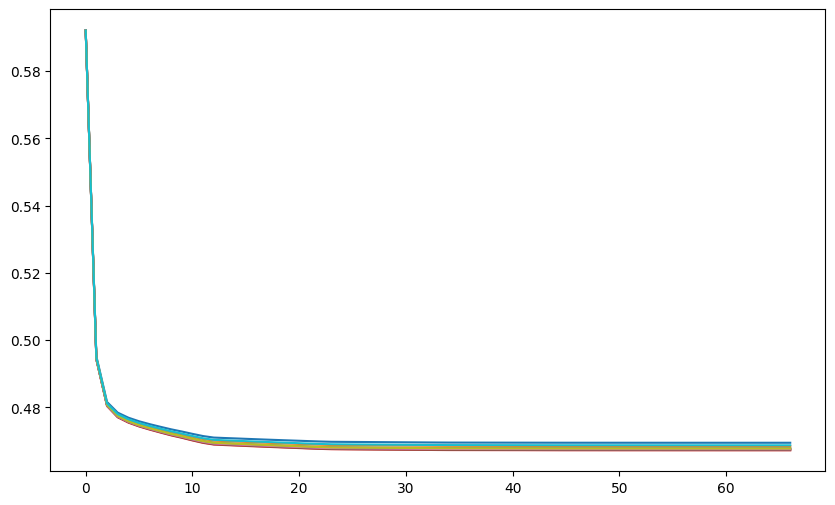

In [33]:
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import precision_recall_fscore_support


# Extract statistical features: mean and std deviation for x and y separately
mean_x = np.mean(train_features[:, :, 0], axis=1)
std_x = np.std(train_features[:, :, 0], axis=1)
mean_y = np.mean(train_features[:, :, 1], axis=1)
std_y = np.std(train_features[:, :, 1], axis=1)

# Combine extracted features into a single feature array
extracted_features = np.vstack((mean_x, std_x, mean_y, std_y)).T

# Initialize the models
rf_model = RandomForestClassifier(random_state=42, oob_score=True)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='sgd',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=1000,
    shuffle=True,
    random_state=42,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=True
)

# Define a custom scoring function
def precision_scorer(y_true, y_pred):
    precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred)
    return precision[1]  # Return precision for positive class

def recall_scorer(y_true, y_pred):
    _, recall, _, _ = precision_recall_fscore_support(y_true, y_pred)
    return recall[1]  # Return recall for positive class

def f1_scorer(y_true, y_pred):
    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred)
    return f1[1]  # Return F1-score for positive class

# Define scoring metrics using make_scorer and the custom scoring functions
scoring_metrics = {
    'precision': make_scorer(precision_scorer),
    'recall': make_scorer(recall_scorer),
    'f1_score': make_scorer(f1_scorer),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")
}

# Perform 10-fold cross-validation
cv_result_rf = cross_validate(
    rf_model,
    extracted_features,
    train_labels,
    cv=10,
    scoring=scoring_metrics
)
cv_result_mlp = cross_validate(
    mlp_model,
    extracted_features,
    train_labels,
    cv=10,
    scoring=scoring_metrics,
    return_estimator=True,  # Make sure to return the models
    return_train_score=False
)

plt.figure(figsize=(10, 6))
for i, model in enumerate(cv_result_mlp['estimator']):
    plt.plot(model.loss_curve_, label=f"Fold {i+1}")


In [34]:
# Calculate mean and standard deviation of the cross-validation scores
mean_scores_rf = {metric: np.mean(values) for metric, values in cv_result_rf.items() if metric != 'estimator'}
std_scores_rf = {metric: np.std(values) for metric, values in cv_result_rf.items() if metric != 'estimator'}
mean_scores_mlp = {metric: np.mean(values) for metric, values in cv_result_mlp.items() if metric != 'estimator'}
std_scores_mlp = {metric: np.std(values) for metric, values in cv_result_mlp.items() if metric != 'estimator'}

In [35]:
# print the results of the cross validation with name of the model
print('Random Forest')
print(mean_scores_rf)
# print(std_scores_rf)
print('MLP')
print(mean_scores_mlp)
# print(std_scores_mlp)

Random Forest
{'fit_time': 0.49151105880737306, 'score_time': 0.027848315238952637, 'test_precision': 0.6528553878089987, 'test_recall': 0.21566322027487078, 'test_f1_score': 0.32375865264155845, 'test_roc_auc': 0.6637394444172408}
MLP
{'fit_time': 6.772344040870666, 'score_time': 0.01990399360656738, 'test_precision': 0.0, 'test_recall': 0.0, 'test_f1_score': 0.0, 'test_roc_auc': 0.6444293182170868}


Iteration 1, loss = 0.52726370
Validation score: 0.796622
Iteration 2, loss = 0.48159072
Validation score: 0.797326
Iteration 3, loss = 0.47209365
Validation score: 0.802252
Iteration 4, loss = 0.46877543
Validation score: 0.802252
Iteration 5, loss = 0.46695107
Validation score: 0.802252
Iteration 6, loss = 0.46561819
Validation score: 0.802252
Iteration 7, loss = 0.46447888
Validation score: 0.802252
Iteration 8, loss = 0.46356341
Validation score: 0.802252
Iteration 9, loss = 0.46282137
Validation score: 0.802252
Iteration 10, loss = 0.46217100
Validation score: 0.802252
Iteration 11, loss = 0.46161221
Validation score: 0.802252
Iteration 12, loss = 0.46112698
Validation score: 0.802252
Iteration 13, loss = 0.46072336
Validation score: 0.802252
Iteration 14, loss = 0.46036884
Validation score: 0.802252
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000020
Iteration 15, loss = 0.46011141
Validation score: 0.802252
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 2, loss = 0.48188971
Validation score: 0.802956
Iteration 3, loss = 0.47237416
Validation score: 0.804363
Iteration 4, loss = 0.46905986
Validation score: 0.804363
Iteration 5, loss = 0.46724428
Validation score: 0.804363
Iteration 6, loss = 0.46591100
Validation score: 0.804363
Iteration 7, loss = 0.46478459
Validation score: 0.804363
Iteration 8, loss = 0.46386374
Validation score: 0.804363
Iteration 9, loss = 0.46307521
Validation score: 0.804363
Iteration 10, loss = 0.46239188
Validation score: 0.804363
Iteration 11, loss = 0.46182265
Validation score: 0.804363
Iteration 12, loss = 0.46131407
Validation score: 0.804363
Iteration 13, loss = 0.46089386
Validation score: 0.804363
Iteration 14, loss = 0.46052196
Validation score: 0.804363
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000020
Iteration 15, loss = 0.46025971
Validation score: 0.804363
Iteration 16, loss = 0.46019246
Validation score: 0.804363
Iterat

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 1, loss = 0.52750883
Validation score: 0.799437
Iteration 2, loss = 0.48166122
Validation score: 0.799437
Iteration 3, loss = 0.47212853
Validation score: 0.803659
Iteration 4, loss = 0.46885805
Validation score: 0.803659
Iteration 5, loss = 0.46712585
Validation score: 0.803659
Iteration 6, loss = 0.46586344
Validation score: 0.803659
Iteration 7, loss = 0.46479142
Validation score: 0.803659
Iteration 8, loss = 0.46392956
Validation score: 0.803659
Iteration 9, loss = 0.46318201
Validation score: 0.803659
Iteration 10, loss = 0.46255403
Validation score: 0.803659
Iteration 11, loss = 0.46200611
Validation score: 0.803659
Iteration 12, loss = 0.46153135
Validation score: 0.803659
Iteration 13, loss = 0.46114421
Validation score: 0.803659
Iteration 14, loss = 0.46079288
Validation score: 0.803659
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000020
Iteration 15, loss = 0.46054732
Validation score: 0.803659
Iterati

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Iteration 2, loss = 0.48137345
Validation score: 0.799437
Iteration 3, loss = 0.47172250
Validation score: 0.803659
Iteration 4, loss = 0.46834269
Validation score: 0.803659
Iteration 5, loss = 0.46652012
Validation score: 0.803659
Iteration 6, loss = 0.46515740
Validation score: 0.803659
Iteration 7, loss = 0.46399974
Validation score: 0.803659
Iteration 8, loss = 0.46306702
Validation score: 0.803659
Iteration 9, loss = 0.46227668
Validation score: 0.803659
Iteration 10, loss = 0.46159548
Validation score: 0.803659
Iteration 11, loss = 0.46101458
Validation score: 0.803659
Iteration 12, loss = 0.46051006
Validation score: 0.803659
Iteration 13, loss = 0.46008964
Validation score: 0.803659
Iteration 14, loss = 0.45971487
Validation score: 0.803659
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.000020
Iteration 15, loss = 0.45945105
Validation score: 0.803659
Iteration 16, loss = 0.45938826
Validation score: 0.803659
Iterat

/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnny/miniconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

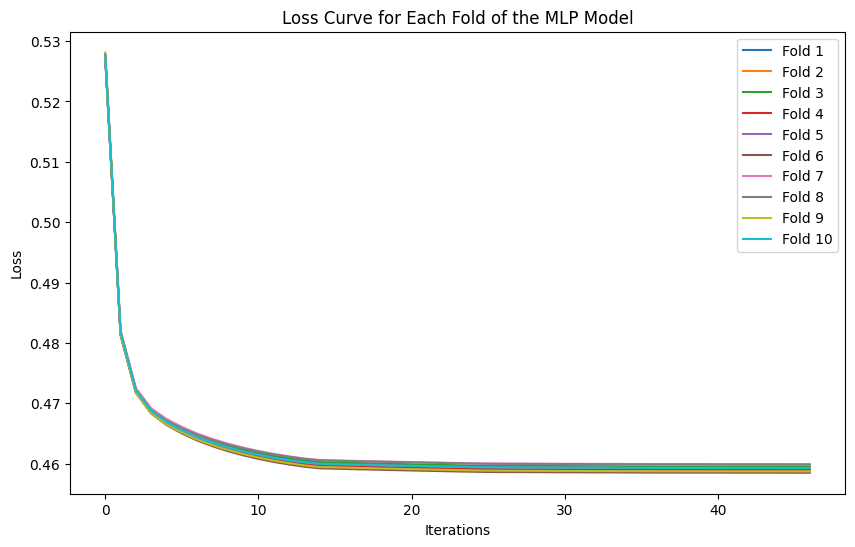

In [36]:
import matplotlib.pyplot as plt

# Flatten the 3D array into a 2D array
input_features = train_features.reshape(train_features.shape[0], -1)

# Perform 10-fold cross-validation for RandomForest using raw train_features
rf_model = RandomForestClassifier(random_state=42, oob_score=True, warm_start=True)
cv_result_rf_raw = cross_validate(
    rf_model,
    input_features,
    train_labels,
    cv=10,
    scoring=scoring_metrics
)

# Perform 10-fold cross-validation for MLP using raw train_features

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='sgd',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.0001,
    max_iter=1000,
    shuffle=True,
    random_state=42,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    verbose=True
)

cv_result_mlp_raw = cross_validate(
    mlp_model,
    input_features,
    train_labels,
    cv=10,
    scoring=scoring_metrics,
    return_estimator=True,  # Make sure to return the models
    return_train_score=False
)

# Plotting the loss curve for each fold of the MLP model
plt.figure(figsize=(10, 6))
for i, model in enumerate(cv_result_mlp_raw['estimator']):
    plt.plot(model.loss_curve_, label=f"Fold {i+1}")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve for Each Fold of the MLP Model")
plt.show()


In [37]:
# Calculate mean and standard deviation of the cross-validation scores
mean_scores_rf = {metric: np.mean(values) for metric, values in cv_result_rf_raw.items() if metric != 'estimator'}
std_scores_rf = {metric: np.std(values) for metric, values in cv_result_rf_raw.items() if metric != 'estimator'}
mean_scores_mlp = {metric: np.mean(values) for metric, values in cv_result_mlp_raw.items() if metric != 'estimator'}
std_scores_mlp = {metric: np.std(values) for metric, values in cv_result_mlp_raw.items() if metric != 'estimator'}

In [38]:
# print the results of the cross validation with name of the model
print('Random Forest')
print(mean_scores_rf)
# print(std_scores_rf)
print('MLP')
print(mean_scores_mlp)
# print(std_scores_mlp)

Random Forest
{'fit_time': 0.9138695478439331, 'score_time': 0.028103733062744142, 'test_precision': 0.6532194654789016, 'test_recall': 0.21598684487034, 'test_f1_score': 0.32416768905520243, 'test_roc_auc': 0.6638999232099}
MLP
{'fit_time': 6.230522918701172, 'score_time': 0.010762977600097656, 'test_precision': 0.26666666666666666, 'test_recall': 0.0012955491110830917, 'test_f1_score': 0.002574461763312374, 'test_roc_auc': 0.622710339927693}
